In [83]:
# import
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

In [84]:
file_path = '../data/processed/Customer_Churn_Dataset_0_impute_label.csv'
df = pd.read_csv(file_path)

drop_cols = ['Unnamed: 0']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

target = 'Churn'
X = df.drop(columns=[target])
y = df[target]

In [86]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=0
)

model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    min_child_samples=20,
    is_unbalance=True,
    random_state= 0,
    force_row_wise=True
)
model.fit(X_train, y_train)

# 추론
pred_train_lgbm = model.predict(X_train)
pred_test_lgbm = model.predict(X_test)

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

print("---------------train set Classification Report---------------")
print(classification_report(y_train, pred_train_lgbm))

print("---------------test set Classification Report---------------")
print(classification_report(y_test, pred_test_lgbm))

[LightGBM] [Info] Number of positive: 1402, number of negative: 3880
[LightGBM] [Info] Total Bins 641
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265430 -> initscore=-1.017935
[LightGBM] [Info] Start training from score -1.017935
---------------train set Classification Report---------------
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      3880
           1       0.81      1.00      0.89      1402

    accuracy                           0.94      5282
   macro avg       0.90      0.95      0.92      5282
weighted avg       0.95      0.94      0.94      5282

---------------test set Classification Report---------------
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      1294
           1       0.66      0.82      0.73       467

    accuracy                           0.84      1761
   m

In [87]:
model.feature_importances_

array([ 222,  117,  165,   81, 1457,   46,  146,   87,  162,  192,  128,
        159,   62,   91,  176,  179,  405, 2126, 2013,  269,  717],
      dtype=int32)

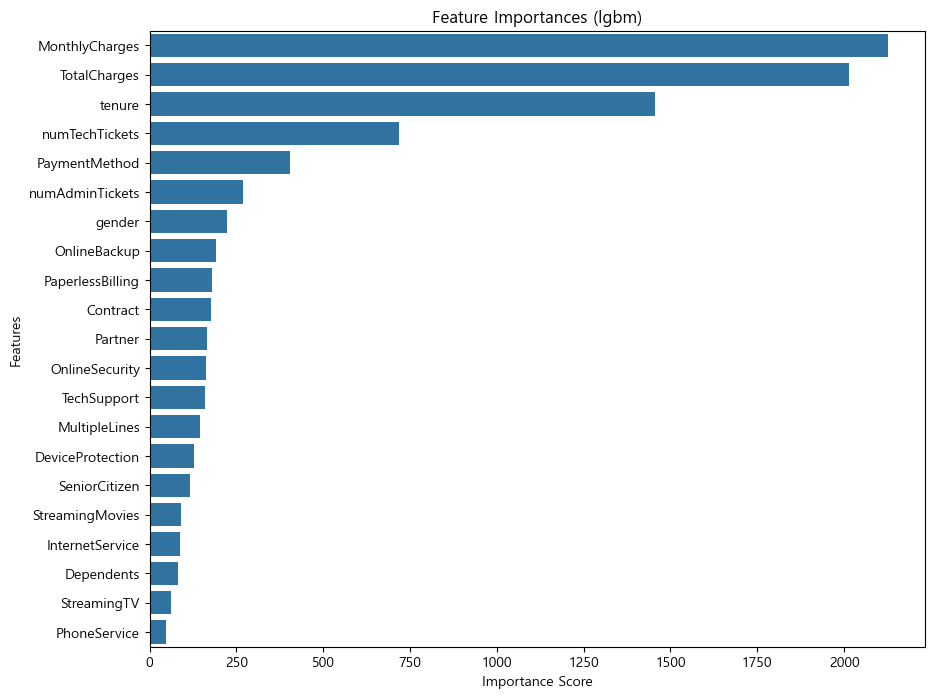

In [88]:
fi = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

importances = model.feature_importances_
feature_names = X_train.columns

# 보기 좋게 정렬하기 위해 Series로 변환
ft_series = pd.Series(importances, index=feature_names)
ft_series = ft_series.sort_values(ascending=False)  # 내림차순 정렬

# 2. 시각화 그리기
plt.figure(figsize=(10, 8))  # 그림 사이즈 조절 (가로, 세로)
plt.title("Feature Importances (lgbm)")

# seaborn을 이용해 가로 막대 그래프 그리기
sns.barplot(x=ft_series, y=ft_series.index)

# 라벨 달기
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

In [89]:
# Permutation Importance check

from sklearn.inspection import permutation_importance

perm = permutation_importance(
    model,
    X_test,
    y_test,
    scoring='f1',   # 꼭 f1 또는 recall 중심
    n_repeats=10,
    random_state=42
)

importances = perm.importances_mean
for col, imp in sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"{col}: {imp}")

numTechTickets: 0.1723645121902297
tenure: 0.11536897257738524
Contract: 0.06299942610511536
MonthlyCharges: 0.04214184864909787
TotalCharges: 0.04089611124757303
OnlineSecurity: 0.021808582794231722
InternetService: 0.013671082789863032
PaymentMethod: 0.0077419601796756225
TechSupport: 0.002633223757077119
MultipleLines: 0.0017680682751710862
SeniorCitizen: 0.000592436663064011
StreamingTV: 0.0005147370100216153
PaperlessBilling: 0.0004398289089050822
PhoneService: 3.108909878146715e-05
Partner: -0.0002932885588926903
Dependents: -0.0003022153597228683
OnlineBackup: -0.0013983730171440167
numAdminTickets: -0.0043375049970058146
DeviceProtection: -0.0051111115322657105
gender: -0.005655792853069186
StreamingMovies: -0.00588890318494345


In [ ]:
high_importance_feature = ['numTechTickets', 'tenure', 'Contract', 'MonthlyCharges', 'TotalCharges']
middle_importance_featrue = ['OnlineSecurity', 'InternetService', 'PaymentMethod',
 'TechSupport', 'MultipleLines']
low_importance_feature = ['SeniorCitizen', 'StreamingTV', 'PaperlessBilling', 'PhoneService',
 'Partner', 'Dependents', 'OnlineBackup', 'numAdminTickets',
 'DeviceProtection', 'gender', 'StreamingMovies']

In [ ]:
# low_importance_feature 제거 후 비교
# 기존 acc = 0.84, f1_score = 0.73, recall = 0.82
# low 제외 후 acc = 0.84, f1_score = 0.73, recall = 0.84
df_except_low = df.drop(columns= low_importance_feature)

target = 'Churn'
X = df_except_low.drop(columns=[target])
y = df_except_low[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=0
)

model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    min_child_samples=20,
    is_unbalance=True,
    random_state= 0,
    force_row_wise=True
)
model.fit(X_train, y_train)

# 추론
pred_train_lgbm = model.predict(X_train)
pred_test_lgbm = model.predict(X_test)

print("---------------train set Classification Report---------------")
print(classification_report(y_train, pred_train_lgbm))

print("---------------test set Classification Report---------------")
print(classification_report(y_test, pred_test_lgbm))

[LightGBM] [Info] Number of positive: 1402, number of negative: 3880
[LightGBM] [Info] Total Bins 611
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265430 -> initscore=-1.017935
[LightGBM] [Info] Start training from score -1.017935
---------------train set Classification Report---------------
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      3880
           1       0.78      0.99      0.87      1402

    accuracy                           0.92      5282
   macro avg       0.89      0.94      0.91      5282
weighted avg       0.94      0.92      0.92      5282

---------------test set Classification Report---------------
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      1294
           1       0.65      0.84      0.73       467

    accuracy                           0.84      1761
   m

In [ ]:
# middle_importance_feature 제거 후 비교
# 기존 acc = 0.84, f1_score = 0.73, recall = 0.82
# low 제외 후 acc = 0.84, f1_score = 0.73, recall = 0.84
# middle 제외 후 acc = 0.89, f1_score = 0.72, recall = 0.85
df_middle_low = df_except_low.drop(columns= middle_importance_featrue)

target = 'Churn'
X = df_middle_low.drop(columns=[target])
y = df_middle_low[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=0
)

model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    min_child_samples=20,
    is_unbalance=True,
    random_state= 0,
    force_row_wise=True
)
model.fit(X_train, y_train)

# 추론
pred_train_lgbm = model.predict(X_train)
pred_test_lgbm = model.predict(X_test)

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

print("---------------train set Classification Report---------------")
print(classification_report(y_train, pred_train_lgbm))

print("---------------test set Classification Report---------------")
print(classification_report(y_test, pred_test_lgbm))

[LightGBM] [Info] Number of positive: 1402, number of negative: 3880
[LightGBM] [Info] Total Bins 595
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265430 -> initscore=-1.017935
[LightGBM] [Info] Start training from score -1.017935
---------------train set Classification Report---------------
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      3880
           1       0.72      0.97      0.83      1402

    accuracy                           0.89      5282
   macro avg       0.85      0.92      0.87      5282
weighted avg       0.92      0.89      0.90      5282

---------------test set Classification Report---------------
              precision    recall  f1-score   support

           0       0.94      0.82      0.87      1294
           1       0.62      0.85      0.72       467

    accuracy                           0.82      1761
   ma

In [ ]:
# middle_importance_feature 제거 후가 더 좋다고 판단했으나, Optuna를 위해 좀 더 feature수가 필요.
# low_importance_feature 제거 상태에서 진행

import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score
import optuna
import numpy as np
import tqdm

In [16]:
high_importance_feature = ['numTechTickets', 'tenure', 'Contract', 'MonthlyCharges', 'TotalCharges']
middle_importance_featrue = ['OnlineSecurity', 'InternetService', 'PaymentMethod',
 'TechSupport', 'MultipleLines']
low_importance_feature = ['SeniorCitizen', 'StreamingTV', 'PaperlessBilling', 'PhoneService',
 'Partner', 'Dependents', 'OnlineBackup', 'numAdminTickets',
 'DeviceProtection', 'gender', 'StreamingMovies']

In [17]:
file_path = '../data/processed/Customer_Churn_Dataset_0_impute_label.csv'
df = pd.read_csv(file_path)

drop_cols = ['Unnamed: 0']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])
df = df.drop(columns= low_importance_feature)

target = 'Churn'
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=0
)

In [19]:
# Optuna 정의
def objective(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "boosting_type": "gbdt",
        "is_unbalance": True,
        "force_row_wise": True,
        "random_state": 0,
        'min_split_gain': 0.0,

        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 40, 100),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 25),

        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.8, 1.0),

        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 0.2),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 0.2),

         "verbose": -1 # info 메시지 가리기
    }

    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    return f1_score(y_test, preds)

# Optuna Study 생성
study = optuna.create_study(
    direction="maximize",
    study_name="lgbm_opt"
)

# 튜닝 시작
study.optimize(objective, n_trials=50)

[I 2025-11-24 15:16:01,367] A new study created in memory with name: lgbm_opt
[I 2025-11-24 15:16:02,414] Trial 0 finished with value: 0.7186858316221766 and parameters: {'n_estimators': 376, 'learning_rate': 0.07515831901508267, 'num_leaves': 88, 'min_child_samples': 19, 'subsample': 0.890728095891084, 'colsample_bytree': 0.8067258528534683, 'reg_alpha': 0.11694439047341061, 'reg_lambda': 0.07677688831340497}. Best is trial 0 with value: 0.7186858316221766.
[I 2025-11-24 15:16:03,751] Trial 1 finished with value: 0.7199170124481328 and parameters: {'n_estimators': 736, 'learning_rate': 0.06756428155392294, 'num_leaves': 54, 'min_child_samples': 18, 'subsample': 0.914486871356631, 'colsample_bytree': 0.8067665456095422, 'reg_alpha': 0.15842316393635347, 'reg_lambda': 0.08809025114423981}. Best is trial 1 with value: 0.7199170124481328.
[I 2025-11-24 15:16:05,501] Trial 2 finished with value: 0.714859437751004 and parameters: {'n_estimators': 742, 'learning_rate': 0.0278207129802091, 'n

In [20]:

# Best Params 출력
print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

Best Params: {'n_estimators': 230, 'learning_rate': 0.015859786991629966, 'num_leaves': 43, 'min_child_samples': 11, 'subsample': 0.8198802762608601, 'colsample_bytree': 0.8253877478886077, 'reg_alpha': 0.18707415666104887, 'reg_lambda': 0.020010155281218016}
Best Score: 0.7436823104693141


In [22]:
# 5. Best Model 재학습
best_model = LGBMClassifier(
    **study.best_params,
    objective="binary",
    is_unbalance=True,
    force_row_wise=True,
    random_state=0
)

best_model.fit(X_train, y_train)

,boosting_type,'gbdt'
,num_leaves,43
,max_depth,-1
,learning_rate,0.015859786991629966
,n_estimators,230
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,11


In [23]:
pred = best_model.predict(X_test)
proba = best_model.predict_proba(X_test)[:, 1]

print("Accuracy :", accuracy_score(y_test, pred))
print("Precision:", precision_score(y_test, pred))
print("Recall   :", recall_score(y_test, pred))
print("F1-score :", f1_score(y_test, pred))
print("ROC-AUC  :", roc_auc_score(y_test, proba))

# low 제외 후 acc = 0.84, f1_score = 0.73, recall = 0.84
# optuna 진행 후 acc = 0.83, f1_score = 0.743, recall = 0.88

Accuracy : 0.8387279954571266
Precision: 0.6427457098283932
Recall   : 0.8822269807280514
F1-score : 0.7436823104693141
ROC-AUC  : 0.9260124971454482


In [25]:
def threshold_search(y_true, y_proba):
    thresholds = np.arange(0.01, 1.00, 0.01)
    best_threshold = 0.5
    best_f1 = 0
    
    results = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        f1 = f1_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)

        results.append([t, f1, recall, precision, accuracy])

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t

    return best_threshold, best_f1, results

y_proba = best_model.predict_proba(X_test)[:, 1]
best_t, best_f1, result_table = threshold_search(y_test, y_proba)

print("Best Threshold:", best_t)
print("Best F1 Score:", best_f1)

Best Threshold: 0.5800000000000001
Best F1 Score: 0.7507218479307026


c:\documents\Project\SKN21-2nd-4Team\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\documents\Project\SKN21-2nd-4Team\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [27]:
final_threshold = 0.58

def predict_with_threshold(model, X, threshold=final_threshold):
    proba = model.predict_proba(X)[:, 1]
    pred = (proba >= threshold).astype(int)
    return pred, proba

final_pred, final_proba = predict_with_threshold(best_model, X_test)

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

print("=== Final Metrics (Threshold Applied) ===")
print("Accuracy:", accuracy_score(y_test, final_pred))
print("Precision:", precision_score(y_test, final_pred))
print("Recall:", recall_score(y_test, final_pred))
print("F1:", f1_score(y_test, final_pred))

=== Final Metrics (Threshold Applied) ===
Accuracy: 0.8529244747302669
Precision: 0.6818181818181818
Recall: 0.8351177730192719
F1: 0.7507218479307026


In [28]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, final_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1112  182]
 [  77  390]]


In [30]:
import joblib
import os

In [ ]:
model_package = {
    "model": best_model,
    "threshold": final_threshold,
    "feature_columns": X_train.columns.tolist()
}

joblib.dump(model_package, "../src/models/ML/model_dir/LGBM_model.pkl")
print("Model + Threshold saved!")


Model + Threshold saved!
